Copyright(C) 2023 Habana Labs, Ltd. an Intel Company.

### Licensed under the Apache License, Version 2.0
You may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.  

# Transfer Learning Example with TensorFlow EfficientDet-D0 

## Introduction

This tutorial demonstrates how to use transfer learning to detect road signs from a publicly available dataset using a pre-trained EfficientDet-D0 model on Habana Gaudi. The EfficientDet-D0 model was pre-trained with MS COCO dataset. In order to use the general features learned by the pre-trained model, it adds new class/box prediction networks on the top of pre-trained model. The weights of the pre-trained model remain frozen and are not updated. Only new prediction networks are trained from scratch.


## Setup

This notebook runs on a Gaudi system with SynapseAI and Gaudi drivers installed. Please refer to [installation guide](https://docs.habana.ai/en/latest/Installation_Guide/index.html) for more information.  Ensure that the five associated .py files are also included the `./root` folder


### Install Dependencies 

Install the required packages as below. 

In [1]:
%pip install pyyaml pycocotools opencv-python lxml scikit-learn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 202.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 217.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 225.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 249.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 135.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 382.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 368.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 259.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 kB 385.2 MB/s eta 0:00:00
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp38-cp38-linux_x86_64.whl size=423715 sha2

Clone the [Model References](https://github.com/HabanaAI/Model-References) repository and add the repository path to your PYTHONPATH environment variable. The transfer learning task depends on Habana's EfficientDet modules in [Model References](https://github.com/HabanaAI/Model-References/tree/master/TensorFlow/computer_vision/efficientdet) repository. 

In [2]:
!git clone -b 1.7.0 https://github.com/HabanaAI/Model-References.git
!export PYTHONPATH=/root/Model-References/TensorFlow/computer_vision/efficientdet:$PYTHONPATH
%cd /root/Model-References/TensorFlow/computer_vision/efficientdet
# move the associated .py files for Transfer learning into the efficientDet folder
%cp ~/*.py ~/Model-References/TensorFlow/computer_vision/efficientdet/

Cloning into 'Model-References'...
remote: Enumerating objects: 14504, done.
remote: Counting objects: 100% (14503/14503), done.
remote: Compressing objects: 100% (6228/6228), done.
remote: Total 14504 (delta 7903), reused 14437 (delta 7868), pack-reused 1
Receiving objects: 100% (14504/14504), 100.74 MiB | 33.55 MiB/s, done.
Resolving deltas: 100% (7903/7903), done.
/root/Model-References/TensorFlow/computer_vision/efficientdet


In [3]:
import sys
sys.path.append('/root/Model-References/TensorFlow/computer_vision/efficientdet')
sys.path.append('/root/Model-References')

### Data Preparation - Download Kaggle Dataset
Please download the road sign detection dataset from [kaggle](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection) and place the annotations and images in the `./road_sign_data/annotations` and `./road_sign_data/images` folders

Users bear sole liability and responsibility to follow and comply with any third party licenses, and Habana Labs disclaims and will bear no liability with respect to users’ use or compliance with third party licenses.

In [4]:
%mkdir road_sign_data
%cd road_sign_data
%mkdir annotations
%mkdir images

/root/Model-References/TensorFlow/computer_vision/efficientdet/road_sign_data


Now that the images are loaded from Kaggle, we need to Copy a handful of the images to be used for inference at the end of the tutorial

In [5]:
%cd images
%mkdir roadsign_infer_input_dir
%cp road415.png road418.png road536.png road560.png road7.png road854.png ./roadsign_infer_input_dir

/root/Model-References/TensorFlow/computer_vision/efficientdet/road_sign_data/images


### Data Preparation - Convert to TFRecord

Convert the data into TFRecord format using `create_roadsign_tfrecord.py`. If you have downloaded the road sign dataset in `./road_sign_data`, the following command will create TFRecord files under `./road_sign_tfrecord`:

In [6]:
%cd /root/Model-References/TensorFlow/computer_vision/efficientdet
%mkdir road_sign_tfrecord
!python3 create_roadsign_tfrecord.py --data_dir ./road_sign_data --output_path ./road_sign_tfrecord/train --set train --num_shards 8
!python3 create_roadsign_tfrecord.py --data_dir ./road_sign_data --output_path ./road_sign_tfrecord/test --set test --num_shards 1

/root/Model-References/TensorFlow/computer_vision/efficientdet
2023-01-09 20:30:12.644509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 20:30:12.754485: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0109 20:30:14.193033 140555461715776 create_roadsign_tfrecord.py:204] writing to output path: ./road_sign_tfrecord/train
I0109 20:30:14.193703 140555461715776 create_roadsign_tfrecord.py:228] Reading from road sign dataset.
I0109 20:30:14.194633 140555461715776 create_roadsign_tf

In the following functions for transfer learning, assume that the dataset is already in TFRecord format.


### Download Pre-trained Checkpoint

To run the transfer learning example, you need to have a pre-trained checkpoint. Habana provides EfficientDet-D0 checkpoint pre-trained on Habana Gaudi. Please download the checkpoint from [Habana Vault](https://vault.habana.ai/artifactory/pretrained-models/checkpoints/1.7.0/TF/EfficientDet/EfficientDet-TensorFlow-2.8.3-1.7.0-665-8n-checkpoint-1.tar.gz).


In [7]:
%mkdir pretrained_ckpt 
%cd pretrained_ckpt
!wget https://vault.habana.ai/artifactory/pretrained-models/checkpoints/1.7.0/TF/EfficientDet/EfficientDet-TensorFlow-2.8.3-1.7.0-665-8n-checkpoint-1.tar.gz
!tar -xvf EfficientDet-TensorFlow-2.8.3-1.7.0-665-8n-checkpoint-1.tar.gz
%cd ~/Model-References/TensorFlow/computer_vision/efficientdet

/root/Model-References/TensorFlow/computer_vision/efficientdet/pretrained_ckpt
--2023-01-09 20:30:25--  https://vault.habana.ai/artifactory/pretrained-models/checkpoints/1.7.0/TF/EfficientDet/EfficientDet-TensorFlow-2.8.3-1.7.0-665-8n-checkpoint-1.tar.gz
Resolving vault.habana.ai (vault.habana.ai)... 35.164.198.2, 54.148.44.92, 54.186.236.167, ...
Connecting to vault.habana.ai (vault.habana.ai)|35.164.198.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://jfrog-prod-usw2-shared-oregon-main.s3.amazonaws.com/aol-hbnartuswest/filestore/d9/d9ebf85cd07f5ed164770795103eeec8a5806aa5?X-Artifactory-username=anonymous&X-Artifactory-repositoryKey=pretrained-models&X-Artifactory-artifactPath=checkpoints%2F1.7.0%2FTF%2FEfficientDet%2FEfficientDet-TensorFlow-2.8.3-1.7.0-665-8n-checkpoint-1.tar.gz&X-Artifactory-projectKey=default&x-jf-traceId=f456073efb8e346e&response-content-disposition=attachment%3Bfilename%3D%22EfficientDet-TensorFlow-2.8.3-1.7.0-665-8n-checkp

## Transfer Learning on Road Sign Detection Dataset

### Import Dependent Modules

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import multiprocessing
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

import numpy as np
import tensorflow.compat.v1 as tf

from absl import flags
from absl import logging

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy

import det_model_fn
import efficientdet_arch

import dataloader_tl
import det_model_fn_tl
import hparams_config_tl
import utils
from inference import InferenceDriver
from inference import restore_ckpt, det_post_process, visualize_image, image_preprocess

from TensorFlow.common.debug import dump_callback
from TensorFlow.common.tb_utils import write_hparams_v1
from pathlib import Path

Using custom Horovod, path: /usr/local/lib/python3.8/dist-packages/horovod/tensorflow/mpi_lib.cpython-38-x86_64-linux-gnu.so


### Load Habana Modules

In [9]:
from habana_frameworks.tensorflow import load_habana_module
load_habana_module()

### Prepare for Transfer Learning

Set up the configurations to prepare for transfer learning. Please make sure to update the `training_file_pattern` and `validation_file_pattern` to point to the preprocessed TFRecord files.

In [10]:
train_batch_size = 2
eval_batch_size = 2
eval_samples = 88
training_file_pattern = './road_sign_tfrecord/train-*'
validation_file_pattern = './road_sign_tfrecord/test-*'
num_examples_per_epoch = 789
num_epochs = 10
model_name = 'efficientdet-d0'
log_every_n_steps = 37
cp_every_n_steps = 1000
keep_checkpoint_max = 5

Define the functions for transfer learning and evaluation steps.

In [11]:
tf.get_logger().propagate = False

tf.disable_v2_behavior()
tf.compat.v1.enable_resource_variables()

def set_env():
    os.environ['TF_ADJUST_HUE_FUSED'] = '1'
    os.environ['TF_ADJUST_SATURATION_FUSED'] = '1'
    os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'
    os.environ['TF_SYNC_ON_FINISH'] = '0'
    os.environ['TF_AUTOTUNE_THRESHOLD'] = '2'

def get_session_config(use_xla):
    config = tf.ConfigProto()

    config.allow_soft_placement = True
    config.log_device_placement = False
    
    config.intra_op_parallelism_threads = 1
    config.inter_op_parallelism_threads = 4

    return config

def build_estimator_params(mode, config, model_dir, ckpt):
  assert mode in ('train', 'eval')
  params = dict(
      config.as_dict(),
      model_name=model_name,
      num_epochs=num_epochs,
      iterations_per_loop=200,
      model_dir=model_dir,
      num_shards=1,
      num_examples_per_epoch=num_examples_per_epoch,
      use_tpu=False,
      backbone_ckpt=None,
      ckpt=ckpt,
      val_json_file=None,
      testdev_dir=None,
      mode=mode,
      dropout_rate=None
  )
  params['every_n_iter'] = log_every_n_steps
  params['dump_all_ranks'] = 0

  if mode == 'train':
    params['batch_size'] = train_batch_size
  else: # 'eval' mode
    params = dict(
      params,
      use_tpu=False,
      input_rand_hflip=False,
      is_training_bn=False,
    )
  return params


def build_estimator_config(mode, config, model_dir):
  assert mode in ('train', 'eval')
  if mode == 'train':
    run_config = tf.estimator.RunConfig(
      session_config=get_session_config(use_xla=False),
      save_checkpoints_steps=cp_every_n_steps,
      log_step_count_steps=log_every_n_steps,
      keep_checkpoint_max=keep_checkpoint_max)
  else: # 'eval' mode
    config_proto = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)

    tpu_config = tf.estimator.tpu.TPUConfig(
      iterations_per_loop=200,
      num_shards=1,
      per_host_input_for_training=tf.estimator.tpu.InputPipelineConfig
        .PER_HOST_V2)

    run_config = tf.estimator.tpu.RunConfig(
      model_dir=model_dir,
      log_step_count_steps=200,
      session_config=config_proto,
      tpu_config=tpu_config,
    )
  return run_config

Instructions for updating:
non-resource variables are not supported in the long term


### Function for Transfer Learning and Evaluation

After setting up the configurations such as input image files, model architectures, etc. the following run function will be used to perform transfer learning and evaluation tasks.

In [12]:
def run(mode, model_dir, ckpt, hparams):
  tf.logging.set_verbosity(tf.logging.FATAL)
  set_env()
    
  config = hparams_config_tl.get_detection_config(model_name)
  config.override(hparams)
    
  model_fn_instance = det_model_fn_tl.get_model_fn(model_name)

    
  if mode == 'train':
    params = build_estimator_params(mode, config, model_dir, ckpt)
    
    run_config = build_estimator_config(mode, config, model_dir)
    
    train_estimator = tf.estimator.Estimator(
            model_fn=model_fn_instance,
            model_dir=model_dir,
            config=run_config,
            params=params)
        
    input_fn = dataloader_tl.InputReaderTL(training_file_pattern,
                                      is_training=True,
                                      params=params,
                                      use_fake_data=False,
                                      is_deterministic=False)
    max_steps = int((num_epochs * num_examples_per_epoch) / (train_batch_size)) + 1
    
    tf.logging.set_verbosity(tf.logging.INFO)
    train_estimator.train(input_fn=input_fn, steps=max_steps)

  elif mode == 'eval':
    eval_params = build_estimator_params(mode, config, model_dir, ckpt)
    eval_config = build_estimator_config(mode, config, model_dir)

    eval_estimator = tf.estimator.tpu.TPUEstimator(
            model_fn=model_fn_instance,
            use_tpu=False,
            train_batch_size=train_batch_size,
            eval_batch_size=eval_batch_size,
            config=eval_config,
            params=eval_params)
    
    for ckpt in tf.train.checkpoints_iterator(
                                            model_dir,
                                            min_interval_secs=0,
                                            timeout=None,
                                            timeout_fn=None):

      logging.info('Starting to evaluate.')

      tf.logging.set_verbosity(tf.logging.INFO)
      eval_results = eval_estimator.evaluate(
                input_fn=dataloader_tl.InputReaderTL(validation_file_pattern,
                is_training=False),
                steps=eval_samples//eval_batch_size)
      logging.info('Eval results: %s', eval_results)

      try:
        current_step = int(os.path.basename(ckpt).split('-')[1])
      except IndexError:
        logging.info('%s has no global step info: stop!', ckpt)
        break

      utils.archive_ckpt(eval_results, eval_results['AP'], ckpt)
      total_step = int((num_epochs * num_examples_per_epoch) / train_batch_size)

      if current_step >= total_step:
        logging.info('Evaluation finished after training step %d', current_step)
        break
  else:
    logging.info('Mode not found.')

In the next step, we perform transfer learning using the pre-trained model as a starting point.

### Transfer Learning

Now we are ready to perform transfer learning for the road sign detection dataset by using the pre-trained model's weights. Transfer learning is to train the last few prediction layers of the EfficientDet-D0 model on the road sign detection dataset while freezing the base networks. The run function is called with the parameters defined by users. Set `pretrained_ckpt` to the path of the pre-trained checkpoint downloaded in the previous step. The trained model will be saved in `model_dir_tl`. Users can pass hyperparameters using `hparams_tl`:
- `num_classes` is the number of object categories in the dataset. It is set to 5 because the road sign detection dataset has 5 classes.  {0: 'background', 1:'traffic light', 2:'stop', 3:'speed limit', 4:'crosswalk'}
- `train_scale_min` and `train_scale_max` are for scale jittering. Each input image is resized with a randomly sampled scale factor between `train_scale_min` and `train_scale_max`.
- `use_bfloat16` enables Habana mixed precision training.
- `var_freeze_expr` is to specify layers to freeze. By setting `var_freeze_expr` to “(efficientnet|fpn_cells|resample_p6)”, all previous layers before the class/box prediction networks are frozen.
- `lr_warmup_epoch` skips learning rate warm-up.

In [13]:
pretrained_ckpt = './pretrained_ckpt/'
model_dir_tl = './roadsign_transfer_learning'
hparams_tl = 'num_classes=5,train_scale_min=0.8,train_scale_max=1.2,use_bfloat16=True,var_freeze_expr="(efficientnet|resample_p6|fpn_cells)",lr_warmup_epoch=0.0'

run('train', model_dir_tl, pretrained_ckpt, hparams_tl)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:ip-172-31-30-151: {
    "name": "efficientdet-d0",
    "image_size": 512,
    "input_rand_hflip": true,
    "train_scale_min": 0.8,
    "train_scale_max": 1.2,
    "autoaugment_policy": null,
    "num_classes": 5,
    "skip_crowd_during_training": true,
    "min_level": 3,
    "max_level": 7,
    "num_scales": 3,
    "aspect_ratios": [
        [
            1.0,
            1.0
        ],
        [
            1.4,
            0.7
        ],
        [
            0.7,
            1

/root/Model-References/TensorFlow/computer_vision/efficientdet/efficientdet_arch.py:96: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  feat = tf.layers.conv2d(
/root/Model-References/TensorFlow/computer_vision/efficientdet/efficientdet_arch.py:119: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  feat = tf.layers.max_pooling2d(
/root/Model-References/TensorFlow/computer_vision/efficientdet/efficientdet_arch.py:516: UserWarning: `tf.layers.separable_conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.SeparableConv2D` instead.
  new_node = conv_op(


INFO:tensorflow:ip-172-31-30-151: fnode 2 : {'width_ratio': 0.0625, 'inputs_offsets': [1, 6]}
INFO:tensorflow:ip-172-31-30-151: fnode 3 : {'width_ratio': 0.125, 'inputs_offsets': [0, 7]}
INFO:tensorflow:ip-172-31-30-151: fnode 4 : {'width_ratio': 0.0625, 'inputs_offsets': [1, 7, 8]}
INFO:tensorflow:ip-172-31-30-151: fnode 5 : {'width_ratio': 0.03125, 'inputs_offsets': [2, 6, 9]}
INFO:tensorflow:ip-172-31-30-151: fnode 6 : {'width_ratio': 0.015625, 'inputs_offsets': [3, 5, 10]}
INFO:tensorflow:ip-172-31-30-151: fnode 7 : {'width_ratio': 0.0078125, 'inputs_offsets': [4, 11]}
INFO:tensorflow:ip-172-31-30-151: building cell %d
INFO:tensorflow:ip-172-31-30-151: fnode 0 : {'width_ratio': 0.015625, 'inputs_offsets': [3, 4]}
INFO:tensorflow:ip-172-31-30-151: fnode 1 : {'width_ratio': 0.03125, 'inputs_offsets': [2, 5]}
INFO:tensorflow:ip-172-31-30-151: fnode 2 : {'width_ratio': 0.0625, 'inputs_offsets': [1, 6]}
INFO:tensorflow:ip-172-31-30-151: fnode 3 : {'width_ratio': 0.125, 'inputs_offsets':

/root/Model-References/TensorFlow/computer_vision/efficientdet/efficientdet_arch.py:180: UserWarning: `tf.layers.separable_conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.SeparableConv2D` instead.
  images = conv_op(
/root/Model-References/TensorFlow/computer_vision/efficientdet/efficientdet_arch.py:199: UserWarning: `tf.layers.separable_conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.SeparableConv2D` instead.
  classes = conv_op(
/root/Model-References/TensorFlow/computer_vision/efficientdet/efficientdet_arch.py:224: UserWarning: `tf.layers.separable_conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.SeparableConv2D` instead.
  images = conv_op(
/root/Model-References/TensorFlow/computer_vision/efficientdet/efficientdet_arch.py:243: UserWarning: `tf.layers.separable_conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Separ

INFO:tensorflow:ip-172-31-30-151: backbone+fpn+box params/flops = 3.830342M, 4.755610185B
global_step:0 - []
efficientnet-b0/stem/conv2d/kernel:0 - [3, 3, 3, 32]
                    /tpu_batch_normalization/gamma:0 - [32]
                                            /beta:0 - [32]
                                            /moving_mean:0 - [32]
                                            /moving_variance:0 - [32]
               /blocks_0/depthwise_conv2d/depthwise_kernel:0 - [3, 3, 32, 1]
                        /tpu_batch_normalization/gamma:0 - [32]
                                                /beta:0 - [32]
                                                /moving_mean:0 - [32]
                                                /moving_variance:0 - [32]
                        /se/conv2d/kernel:0 - [1, 1, 32, 8]
                                  /bias:0 - [8]
                           /conv2d_1/kernel:0 - [1, 1, 8, 32]
                                    /bias:0 - [32]
              

### Evaluate the Model

After the transfer learning process completes, now we are ready to evalute the model. To check the accuracy, call the previously defined run function in 'eval' mode.

In [14]:
run('eval', model_dir_tl, model_dir_tl, hparams_tl)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running eval on CPU/GPU
INFO:tensorflow:ip-172-31-30-151: {
    "name": "efficientdet-d0",
    "image_size": 512,
    "input_rand_hflip": false,
    "train_scale_min": 0.8,
    "train_scale_max": 1.2,
    "autoaugment_policy": null,
    "num_classes": 5,
    "skip_crowd_during_training": true,
    "min_level": 3,
    "max_level": 7,
    "num_scales": 3,
    "aspect_ratios": [
        [
            1.0,
            1.0
        ],
        [
            1.4,
            0.7
        ],
        [
            0.7,
            1.4
        ]
    ],
    "anchor_scale": 4.0,
    "is_training_bn": false,
    "momentum": 0.9,
    "learning_rate": 0.08,
    "lr_warmup_init": 0.008,
    "lr_warmup_epoch": 0.0,
    "first_lr_drop_epoch": 200.0,
    "second_lr_drop_epoch": 250.0,
    "clip_gradients_norm": 10.0,
    "num_epochs": 10,
    "alpha": 0.25,
    "gamma": 1.5,
    "delta": 0.1,
    "box_loss_weight": 50.0,
    "weight_decay": 4e-05,
    "use_

### Inference Examples

Now, let's visualize our transfer learning results by predicting object detection from the test dataset.
The following source code loads the model architecture, restore weights from the finetuned model and then perform the inference. The inference results are visualized with predicted probabilities and bounding boxes.

INFO:tensorflow:ip-172-31-30-151: {
    "name": "efficientdet-d0",
    "image_size": 512,
    "input_rand_hflip": true,
    "train_scale_min": 0.1,
    "train_scale_max": 2.0,
    "autoaugment_policy": null,
    "num_classes": 5,
    "skip_crowd_during_training": true,
    "min_level": 3,
    "max_level": 7,
    "num_scales": 3,
    "aspect_ratios": [
        [
            1.0,
            1.0
        ],
        [
            1.4,
            0.7
        ],
        [
            0.7,
            1.4
        ]
    ],
    "anchor_scale": 4.0,
    "is_training_bn": false,
    "momentum": 0.9,
    "learning_rate": 0.08,
    "lr_warmup_init": 0.008,
    "lr_warmup_epoch": 1.0,
    "first_lr_drop_epoch": 200.0,
    "second_lr_drop_epoch": 250.0,
    "clip_gradients_norm": 10.0,
    "num_epochs": 300,
    "alpha": 0.25,
    "gamma": 1.5,
    "delta": 0.1,
    "box_loss_weight": 50.0,
    "weight_decay": 4e-05,
    "use_bfloat16": false,
    "box_class_repeats": 3,
    "fpn_cell_repeats": 3,
 

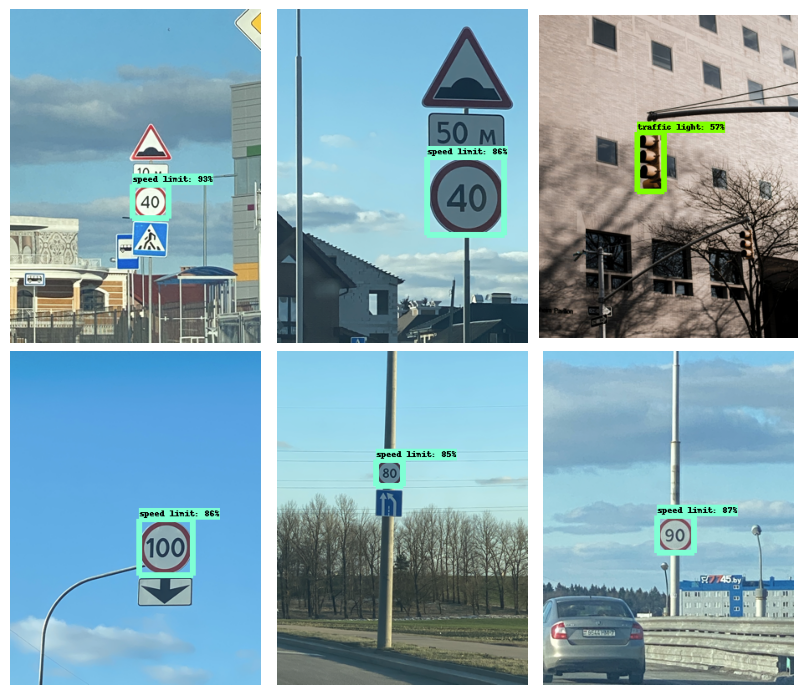

In [15]:
%matplotlib inline

def build_inputs(image_path_pattern, image_size):
  """Read and preprocess input images.

  Args:
    image_path_pattern: a path to indicate a single or multiple files.
    image_size: a single integer for image width and height.

  Returns:
    (raw_images, images, scales): raw images, processed images, and scales.

  Raises:
    ValueError if image_path_pattern doesn't match any file.
  """
  raw_images, images, scales = [], [], []
  for f in tf.io.gfile.glob(image_path_pattern):
    image = Image.open(f)
    image = image.convert('RGB')
    raw_images.append(image)
    image, scale = image_preprocess(image, image_size)
    images.append(image)
    scales.append(scale)
  if not images:
    raise ValueError(
        'Cannot find any images for pattern {}'.format(image_path_pattern))
  return raw_images, tf.stack(images), tf.stack(scales)

def build_model(model_name, inputs, config):
    model_arch = det_model_fn.get_model_arch(model_name)
    class_outputs, box_outputs = model_arch(inputs, model_name=model_name, config=config)
    return class_outputs, box_outputs

tf.reset_default_graph()
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_resource_variables()

image_path_pattern = "./road_sign_data/images/roadsign_infer_input_dir/*.png"
label_id_mapping = {1:'traffic light', 2:'stop', 3:'speed limit', 4:'crosswalk'}

config = hparams_config_tl.get_detection_config(model_name)
config.update(dict(dropout_rate=None, batch_size=1, is_training_bn=False, use_bfloat16=False, num_classes=5))

sess = tf.Session()
raw_images, images, scales = build_inputs(image_path_pattern, 512)
class_outputs, box_outputs = build_model(model_name, images, config)

restore_ckpt(sess, model_dir_tl, enable_ema=False, export_ckpt=None)
config.update(dict(batch_size=len(raw_images),disable_pyfun=False))
detections_batch = det_post_process(config.as_dict(), class_outputs, box_outputs, scales)
outputs_np = sess.run(detections_batch) # [image_id, y, x, height, width, score, class]


fig, ax = plt.subplots(2,3,figsize=(8,8),layout="compressed")
ax = ax.flatten()
for i, output_np in enumerate(outputs_np):
    boxes = output_np[:, 1:5]
    classes = output_np[:, 6].astype(int)
    scores = output_np[:, 5]
    
    boxes[:, [0, 1, 2, 3]] = boxes[:, [1, 0, 3, 2]] # [x, y, width, height] to [ymin, xmin, ymax, xmax]

    boxes[:, 2:4] += boxes[:, 0:2]
    img = visualize_image(raw_images[i], boxes, classes, scores,
                        id_mapping=label_id_mapping, min_score_thresh=0.4, line_thickness=7)
    ax[i].imshow(img)
    ax[i].axis('off')
  
plt.show()